# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 37$
    - источник 1: $p_1 = 100$, $\theta_1 = 73$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="vars/var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)



вариант 7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
from numba import njit, prange

In [ ]:
# Параметры задачи
D0 = 1.0  # Коэффициент диффузии основного материала
D1 = 1e-2 # Коэффициент диффузии включений
p0, theta0 = 100, 37 # Параметры источника 0
p1, theta1 = 100, 73 # Параметры источника 1
Nx= [60, 120, 240, 480, 960]
T0 = 0.0 # Начальная температура
tm = 600


# Расположение источников тепла и включений
sources = [(5, 10, 20, 40, p0, theta0), (20, 40, 5, 10, p1, theta1)] # Источники
probes = [(20, 20), (20, 40), (40, 40), (40, 20)]  # Пробы

In [ ]:
def generate_diffusion_matrix(N):
  """
Создаёт матрицу коэффициентов диффузии для сетки

Параметры:
----------
N : int Размер сетки

Возвращает:
----------
diffusion_matrix : ndarray
Матрица коэффициентов диффузии
"""
  diffusion_matrix = np.full((N, N), D0) # Инициализация матрицы коэффициентов диффузии

# Определяем координаты включений. Разбиваем на 4 простых
  regions = [
  ((10, 15), (10, 30)),
  ((15, 25), (25, 30)),
  ((20, 25), (10, 15)),
  ((25, 30), (10, 30))
  ]

  for x_range, y_range in regions:
    x_start, x_end = int(x_range[0] * N / 60), int(x_range[1] * N / 60)
    y_start, y_end = int(y_range[0] * N / 60), int(y_range[1] * N / 60)

    diffusion_matrix[y_start:y_end, x_start:x_end] = D1

  return diffusion_matrix

@njit(parallel=True)
def compute_temperature_step(current_temp, diffusion_matrix, heat_sources, time_step, space_step, current_time, grid_size):
    """
    Вычисляет новое поле температур на основе текущего состояния.

    Параметры:
    current_temp : np.ndarray
        Текущая матрица температур.
    diffusion_matrix : np.ndarray
        Матрица коэффициентов диффузии.
    heat_sources : list of tuples
        Список источников тепла (координаты и параметры).
    time_step : float
        Шаг времени.
    space_step : float
        Шаг по пространству.
    current_time : float
        Текущее время моделирования.
    grid_size : int
        Размер сетки.

    Возвращает:
    np.ndarray
        Новая матрица температур.
    """
    updated_temp = current_temp.copy()
    for i in prange(1, grid_size - 1):
        for j in range(1, grid_size - 1):
            dTdx2 = (current_temp[i + 1, j] - 2 * current_temp[i, j] + current_temp[i - 1, j]) / space_step**2
            dTdy2 = (current_temp[i, j + 1] - 2 * current_temp[i, j] + current_temp[i, j - 1]) / space_step**2
            updated_temp[i, j] += diffusion_matrix[i, j] * (dTdx2 + dTdy2) * time_step

    # Граничные условия
    updated_temp[:, 0] = 0
    updated_temp[0, :] = 0
    updated_temp[:, -1] = updated_temp[:, -2]
    updated_temp[-1, :] = updated_temp[-2, :]

    # Учёт источников тепла
    for x_start, x_end, y_start, y_end, intensity, frequency in heat_sources:
        i_start, i_end = int(x_start * grid_size / 60), int(x_end * grid_size / 60)
        j_start, j_end = int(y_start * grid_size / 60), int(y_end * grid_size / 60)
        for j in range(j_start, j_end + 1):
            for i in range(i_start, i_end + 1):
                updated_temp[j, i] += intensity * (np.sin(2 * np.pi * frequency * current_time) + 1) * time_step

    return updated_temp

# Основной цикл моделирования
def run_simulation(Nx, D0, D1, T0, tm, sources, probes):
    """
    Выполняет моделирование теплового распределения для заданных параметров.

    Параметры:
    Nx : list of int
        Список размеров сетки (количество узлов вдоль одной стороны).
    D0 : float
        Коэффициент диффузии основного материала.
    D1 : float
        Коэффициент диффузии включений.
    T0 : float
        Начальная температура.
    tm : float
        Общее время моделирования (в секундах).
    sources : list of tuples
        Параметры источников тепла.
    inclusions : list of tuples
        Координаты включений.
    probes : list of tuples
        Координаты проб.

    Возвращает:
    dict
        Результаты моделирования для каждого размера сетки.
    """
    simulation_results = {}
    for grid_size in Nx:
        print(f"Запуск моделирования для сетки {grid_size}x{grid_size}")

        space_step = 60 / grid_size
        time_step = 0.25 * space_step**2 / D0  # Условие устойчивости
        total_steps = int(tm / time_step)

        temperature_field = np.full((grid_size, grid_size), T0)
        diffusion_matrix = generate_diffusion_matrix(grid_size)
        probe_readings = {probe: [] for probe in probes}

        start_time = time.time()

        for step in range(total_steps):
            current_time = step * time_step
            temperature_field = compute_temperature_step(
                temperature_field, diffusion_matrix, sources, time_step, space_step, current_time, grid_size
            )

            # Запись температур в точках проб
            for probe in probes:
                x_idx, y_idx = map(lambda v: int(v * grid_size / 60), probe)
                probe_readings[probe].append(temperature_field[y_idx, x_idx])

        end_time = time.time()
        computation_time = end_time - start_time

        print(f"Время расчёта для сетки {grid_size}x{grid_size}: {computation_time:.2f} секунд")

        simulation_results[grid_size] = {
            "final_temperature": temperature_field,
            "probe_readings": probe_readings,
            "computation_time": computation_time
        }

        np.save(f"final_temperature_grid_{grid_size}.npy", temperature_field)
        np.save(f"probe_readings_grid_{grid_size}.npy", probe_readings)

    return simulation_results
simulation_results=run_simulation(Nx, D0, D1, T0, tm, sources, probes)
simulation_results


Запуск моделирования для сетки 60x60
Время расчёта для сетки 60x60: 6.08 секунд
Запуск моделирования для сетки 120x120
Время расчёта для сетки 120x120: 2.59 секунд
Запуск моделирования для сетки 240x240
Время расчёта для сетки 240x240: 16.13 секунд
Запуск моделирования для сетки 480x480
Время расчёта для сетки 480x480: 144.97 секунд
Запуск моделирования для сетки 960x960
Время расчёта для сетки 960x960: 2244.23 секунд


{60: {'final_temperature': array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,  16.87207897,  33.88975141, ...,  89.09206361,
           87.97355393,  87.97355393],
         [  0.        ,  33.62494271,  67.48641957, ..., 177.1506899 ,
          174.9399668 , 174.9399668 ],
         ...,
         [  0.        ,  88.72968115, 176.4307425 , ..., 426.23066747,
          425.52804961, 425.52804961],
         [  0.        ,  87.61686024, 174.23126248, ..., 425.52378387,
          424.82023419, 424.82023419],
         [  0.        ,  87.61686024, 174.23126248, ..., 425.52378387,
          424.82023419, 424.82023419]]),
  'probe_readings': {(20, 20): [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    4.768371582031251e-13,
    4.036426544189452e-12,
    9.046229814578593e-06,
    2.943829947277711e-05,
    8.523433274779673e-05,
    0.0001840433909669147,
    0.0003679343640

Карта коэффицентов диффузии

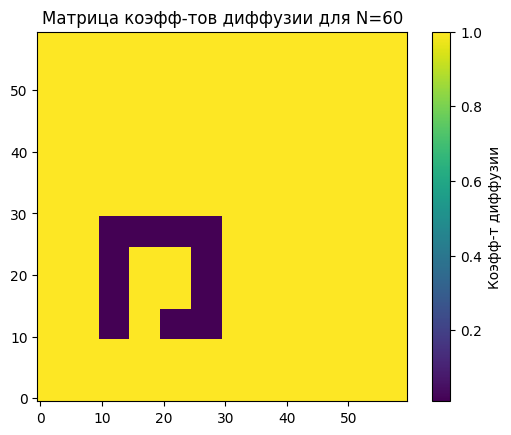

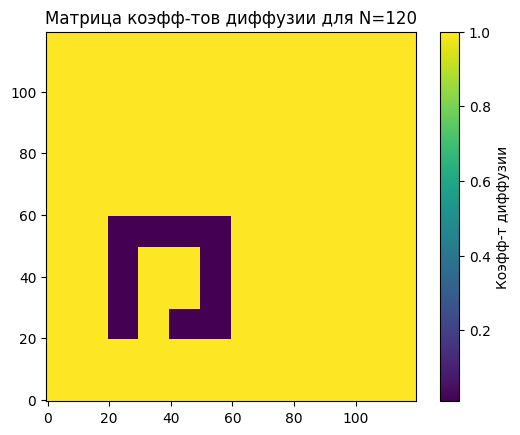

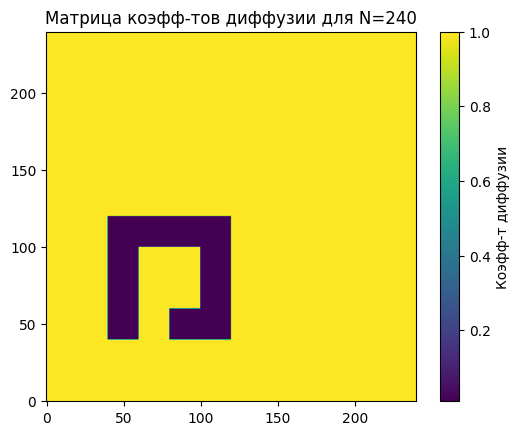

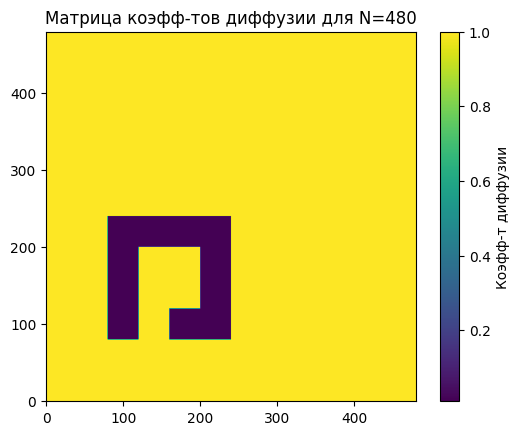

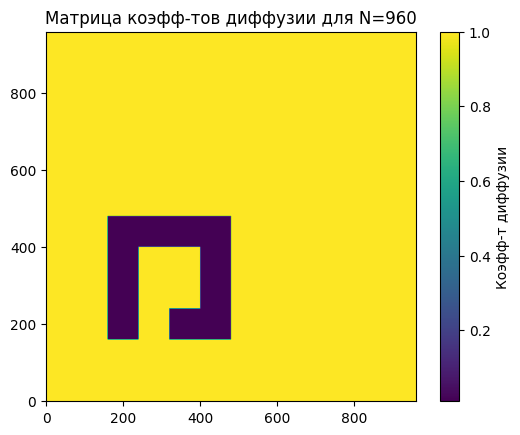

In [ ]:
for N in Nx:
  plt.figure()
  diffusion_matrix = generate_diffusion_matrix(N)
  plt.imshow(diffusion_matrix, cmap='viridis', origin='lower')
  plt.colorbar(label="Коэфф-т диффузии")
  plt.title(f"Матрица коэфф-тов диффузии для N={N}")
  plt.savefig(f"diffusion_matrix_N{N}.png")

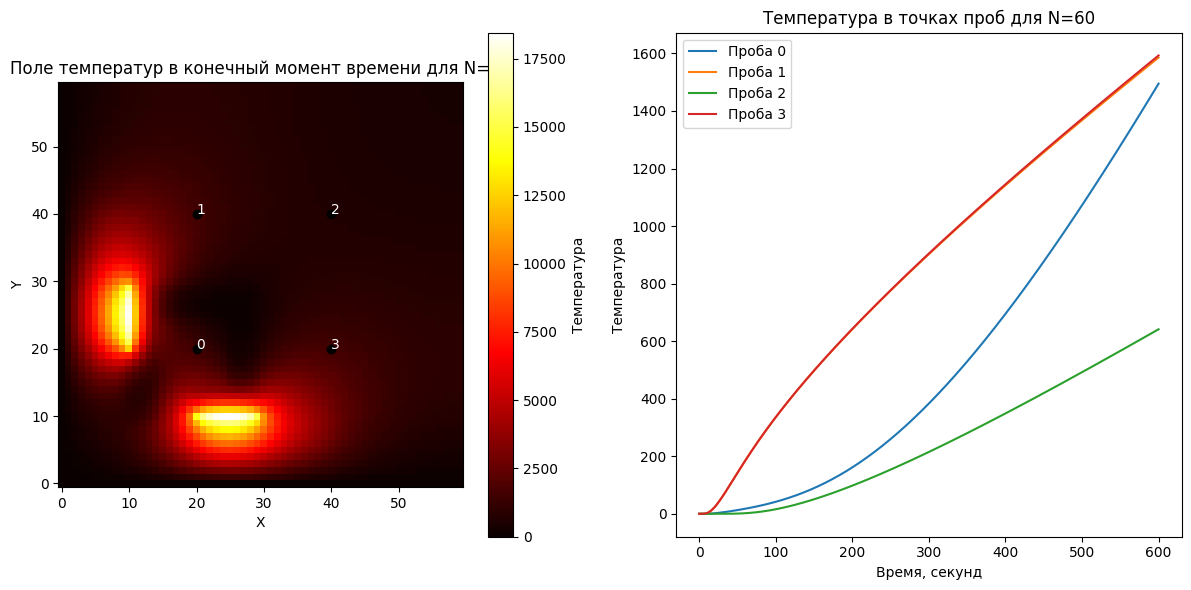

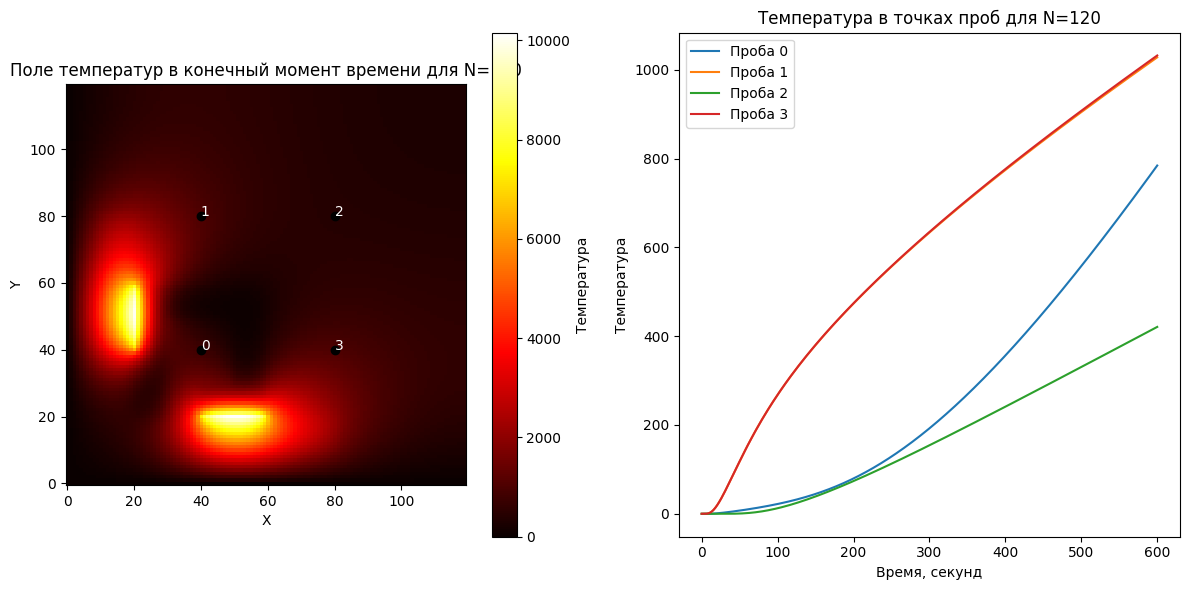

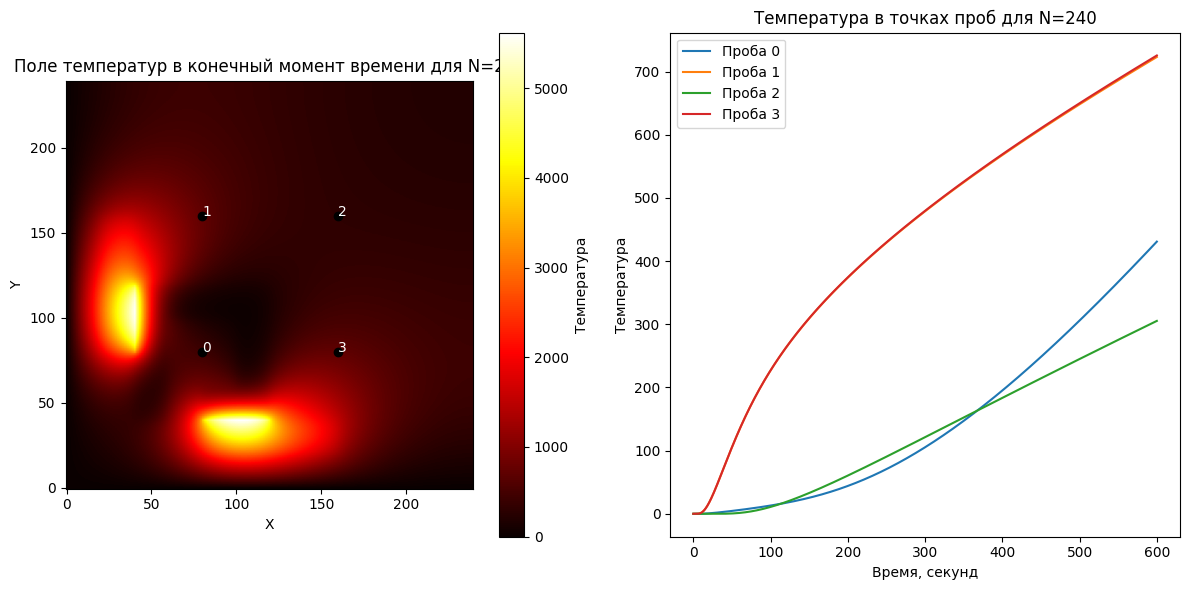

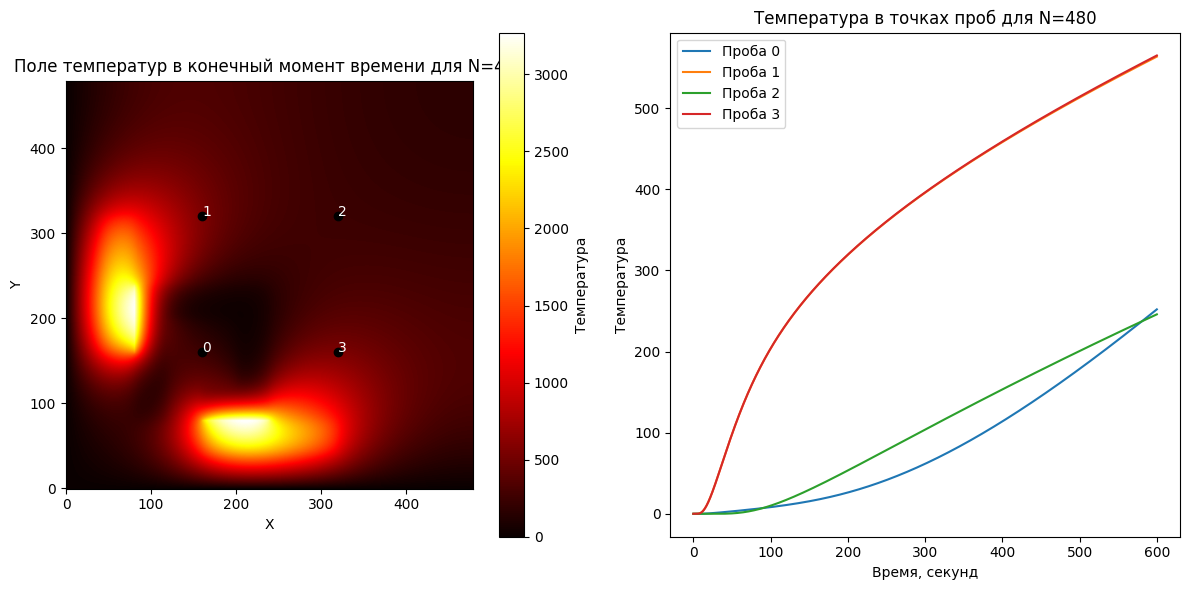

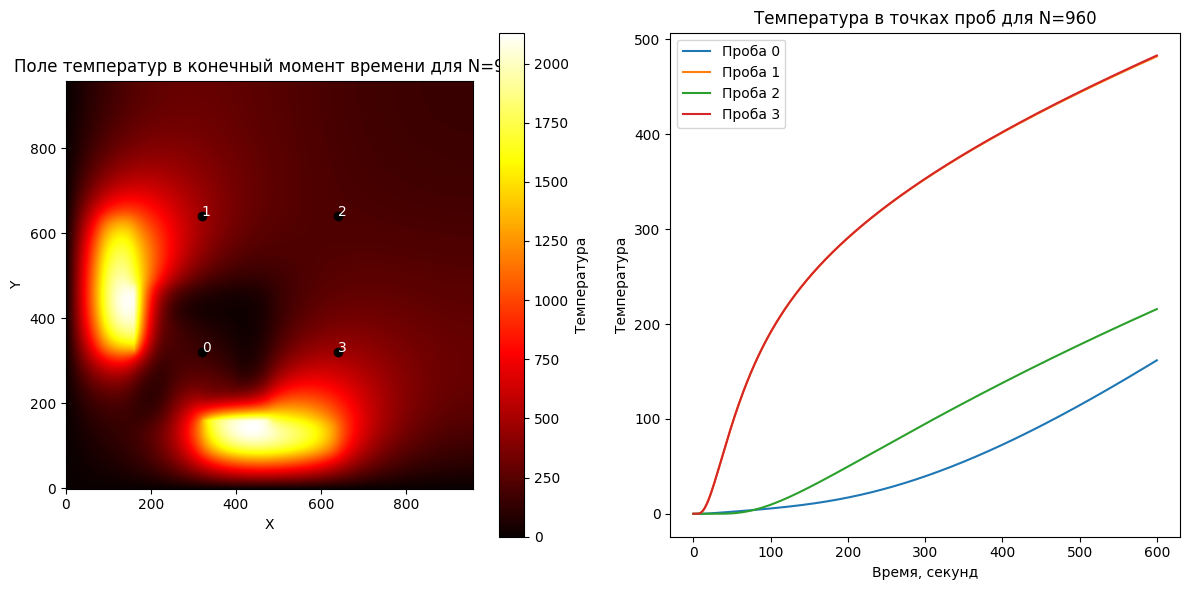

In [ ]:
for N in Nx:
    T = np.load(f"final_temperature_grid_{N}.npy")
    probe_temps = np.load(f"probe_readings_grid_{N}.npy", allow_pickle=True).item()

    # Создаём фигуру с двумя графиками в одной строке (горизонтально)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Поле температур
    im = axs[0].imshow(T, cmap='hot', origin='lower')
    axs[0].set_title(f"Поле температур в конечный момент времени для N={N}")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    fig.colorbar(im, ax=axs[0], label="Температура")

    # Размещение меток проб
    for idx, (x, y) in enumerate(probes):
        x_idx, y_idx = int(x * N / 60), int(y * N / 60)
        axs[0].plot(x_idx, y_idx, 'ko')
        axs[0].text(x_idx, y_idx, str(idx), color='white')

    # Графики температур в точках проб
    time_steps = np.linspace(0, tm, len(probe_temps[probes[0]]))  # Временная ось
    for idx, probe in enumerate(probes):
        axs[1].plot(time_steps, probe_temps[probe], label=f"Проба {idx}")

    axs[1].set_title(f"Температура в точках проб для N={N}")
    axs[1].set_xlabel("Время, секунд")
    axs[1].set_ylabel("Температура")
    axs[1].legend()

    # Сохранение графиков
    plt.tight_layout()  # Для лучшего размещения графиков
    plt.savefig(f"temperature_combined_{N}.png")


In [ ]:
# Анализ частотного спектра
def analyze_frequency_spectrum(simulation_results, probes, dt):
    """
    Анализирует частотный спектр температурных данных для каждой пробы.

    Параметры:
    simulation_results : dict
        Результаты моделирования для каждой сетки.
    probes : list of tuples
        Координаты проб, для которых нужно провести анализ.
    dt : float
        Шаг времени моделирования.

    Вывод:
    ----------
    Печатает основную частоту колебаний температуры для каждой пробы.
    """
    for N in simulation_results.keys():
        probe_temps = simulation_results[N]["probe_readings"]  # Температуры в точках проб для N

        for idx, probe in enumerate(probes):
            temps = probe_temps[probe]  # Температуры для текущей пробы
            fft_result = np.fft.rfft(temps)  # БПФ
            # Changed line: Using dt instead of time_steps
            freqs = np.fft.rfftfreq(len(temps), d=dt)  # Частоты для БПФ

            # Находим пики в спектре
            peaks, _ = find_peaks(np.abs(fft_result))  # Ищем пики на спектре

            # Основная частота - это частота первого пика (если пики есть)
            dominant_freq = freqs[peaks[0]] if peaks.size > 0 else 0
            print(f"Основная частота колебаний температуры для пробы {idx} при N={N}: {dominant_freq:.2f} Гц")


time_step = 0.25 * (60 / Nx[0])**2 / D0

analyze_frequency_spectrum(simulation_results, probes, time_step)

Основная частота колебаний температуры для пробы 0 при N=60: 0.00 Гц
Основная частота колебаний температуры для пробы 1 при N=60: 0.00 Гц
Основная частота колебаний температуры для пробы 2 при N=60: 0.00 Гц
Основная частота колебаний температуры для пробы 3 при N=60: 0.00 Гц
Основная частота колебаний температуры для пробы 0 при N=120: 0.00 Гц
Основная частота колебаний температуры для пробы 1 при N=120: 2.00 Гц
Основная частота колебаний температуры для пробы 2 при N=120: 2.00 Гц
Основная частота колебаний температуры для пробы 3 при N=120: 2.00 Гц
Основная частота колебаний температуры для пробы 0 при N=240: 0.00 Гц
Основная частота колебаний температуры для пробы 1 при N=240: 2.00 Гц
Основная частота колебаний температуры для пробы 2 при N=240: 2.00 Гц
Основная частота колебаний температуры для пробы 3 при N=240: 2.00 Гц
Основная частота колебаний температуры для пробы 0 при N=480: 0.00 Гц
Основная частота колебаний температуры для пробы 1 при N=480: 2.00 Гц
Основная частота колебан

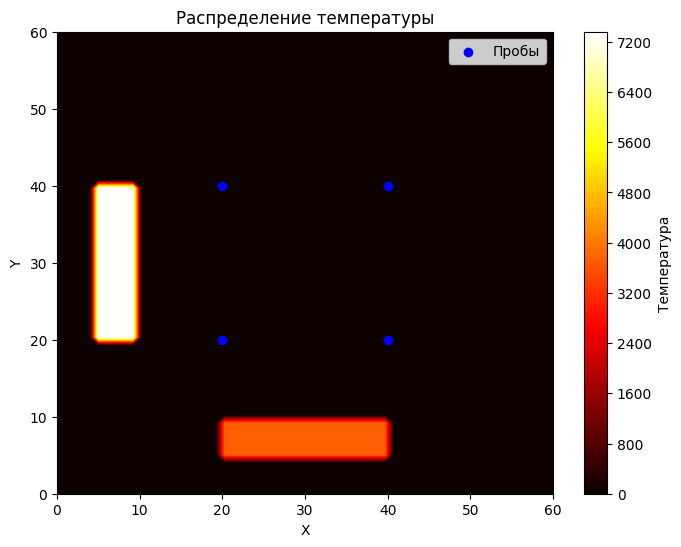

In [ ]:
# Параметры модели
Nx = 60
Lx, Ly = 60, 60  # Размеры области
dx, dy = Lx / Nx, Ly / Nx

# Создание сетки
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Nx)
X, Y = np.meshgrid(x, y)

# Параметры источников
p0, theta0 = 100, 37  # Параметры источника 1
p1, theta1 = 100, 73  # Параметры источника 2

# Источники тепла
def add_source(T, x_start, x_end, y_start, y_end, power, theta):
    T[y_start:y_end, x_start:x_end] += power * theta
    return T

# Начальная температура
T = np.zeros((Nx, Nx))

# Добавление источников тепла
T = add_source(T, 20, 40, 5, 10, p0, theta0)  # Источник 1
T = add_source(T, 5, 10, 20, 40, p1, theta1)  # Источник 2

# Включения
D1 = 0.01  # Коэффициент диффузии включений
inclusion = np.zeros_like(T)
inclusion[15:25, 15:25] = D1

# Построение карты температуры
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, T, levels=100, cmap='hot')
plt.colorbar(label="Температура")
plt.scatter(*zip(*[(20, 20), (20, 40), (40, 40), (40, 20)]), color='blue', label="Пробы")  # Пробы
plt.legend()
plt.title("Распределение температуры")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
